In [1]:
import pandas as pd
import glob
import pyBigWig
import seaborn as sns
data='/labs/mpsnyder/moqri/data/meth/wg/mice/'
mm_='http://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/mm10.chromAlias.txt'
ez_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE94nnn/GSE94300/suppl/GSE94300_E14Ezh2_MAnorm_unbiased.bed.gz'
h_='http://smithdata.usc.edu/methbase/data/Stadler-Mouse-2011/Mouse_ESC/tracks_mm10/Mouse_ESC.meth.bw'
meta_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE80nnn/GSE80672/matrix/GSE80672_series_matrix.txt.gz'

In [158]:
h=pyBigWig.open(h_)
h1=h.intervals("chr"+str(1))
print(len(h1))
h1=pd.DataFrame(h1)
h1.index=h1[1]
h1=h1[2]
h1l=h1[h1<.5]
h1l.shape

1471976


(245955,)

In [162]:
h1

,0,1,2
0,3010492,3010493,0.882353
1,3010644,3010645,1.000000
2,3010819,3010820,0.000000
3,3011264,3011265,1.000000
4,3011312,3011313,0.625000
...,...,...,...
1471971,195368792,195368793,0.692308
1471972,195368860,195368861,1.000000
1471973,195369042,195369043,0.937500
1471974,195369099,195369100,0.380952


In [2]:
mm=pd.read_table(mm_,index_col=1)
mm.shape

(66, 3)

In [3]:
mm.columns=['','','ch']
mm.head(1)

,,,ch
NC_000067.6,chr1,CM000994.2,1


In [4]:
meta=pd.read_table(meta_,skiprows=34,header=None).T

In [5]:
meta=meta[meta[5]=='Whole Blood']

In [6]:
meta=meta[meta[11]=='genetic condition: Wild Type']
meta['gsm']=meta[46].str[3:]
meta['age']=meta[9].str.strip('age (years): ').astype(float)
meta.index=meta.gsm

In [7]:
all_files = glob.glob(data + "*.gz")
li = []
for f in all_files:
    gsm=f.split('GSM')[1].split('_')[0]
    if gsm in meta.gsm.tolist():
        print('',end='-')
        df= pd.read_table(f, index_col=None, header=0, usecols=[1])
        df.columns=[gsm]
        li.append(df)
df = pd.concat(li, axis=1)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df.to_csv(data+m.csv)

In [71]:
ezs=[]
ez=pd.read_table(ez_,header=None)
ez.columns=['chrom', 'chromStart', 'chromEnd']
print(ez.shape)
for ch in range(1,20):
    ezc=ez[ez['chrom']=='chr'+str(ch)]
    print(len(ezc),end=',')
    ezc['r']=ezc.apply(lambda x:range(x['chromStart'],x['chromEnd']),1)
    ezc=ezc['r'].tolist()
    ezc=set([item for sublist in ezc for item in sublist])   
    print(len(ezc),end='-')
    for b in ezc:
        ezs.append([str(ch),b])

(7213, 3)
462,526102-

/home/moqri/anaconda3/envs/stem/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


687,899107-337,395428-455,508115-474,596826-400,520490-438,488638-400,473660-374,426816-293,335768-536,651924-332,389072-351,426337-286,369904-320,377446-155,193966-266,307134-252,284005-227,286329-

In [72]:
ezs=pd.DataFrame(ezs)
ezs.columns=['ch','pos']
ezs['ez']=True

In [75]:
m= pd.read_table(all_files[0], index_col=None, header=0)
m.columns=['i','p','c']
m['m_ch']=m.i.str.split('|').str[3]
m['pos']=m.i.str.split('|').str[4].str.strip(':').astype(int)

In [76]:
ma=m.merge(mm[['ch']],left_on='m_ch',right_index=True)
ma.shape

(1976975, 6)

In [61]:
ma['ch']=pd.to_numeric(ma.ch,errors='coerce')
ma=ma.loc[ma.ch.dropna().index]
ma['ch']=ma.ch.astype(int)

In [77]:
me=ma.merge(ezs,left_on=['ch','pos'],right_on=['ch','pos'],how='left')
me.shape

(1976975, 7)

In [75]:
#mh=me[me.pos.isin(h1.index)]

In [151]:
m2=me[(me.pos.isin(ezs[ezs.ch=='2'].pos))&(me.ch=='2')]

In [82]:
mez=me[me.pos.isin(ezs.pos)]

<ipython-input-155-54426f4b21dc>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dg=pd.concat([df.loc[m2.index].mean(),meta[[12,'age']].loc[df.columns]],1)


<AxesSubplot:xlabel='age', ylabel='0'>

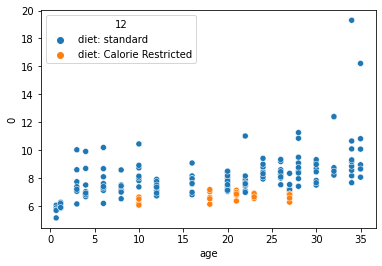

In [155]:
dg=pd.concat([df.loc[m2.index].mean(),meta[[12,'age']].loc[df.columns]],1)
sns.scatterplot(data=dg[dg[0]<20],x='age',y=0,hue=12)

In [156]:
dg.corr()

,0,age
0,1.000000,0.469115
age,0.469115,1.000000


<AxesSubplot:xlabel='age', ylabel='0'>

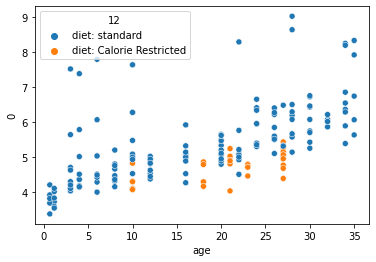

In [326]:
sns.scatterplot(data=dg[dg[0]<10],x='age',y=0,hue=12)

In [108]:
m1

,i,p,c,m_ch,pos,ch,ez
1860913,gi|372099109|ref|NC_000067.6|:10232210,0.0,12,NC_000067.6,10232210,1,True
1860914,gi|372099109|ref|NC_000067.6|:10232218,0.0,12,NC_000067.6,10232218,1,True
1860915,gi|372099109|ref|NC_000067.6|:10232239,0.0,40,NC_000067.6,10232239,1,True
1860916,gi|372099109|ref|NC_000067.6|:10232240,0.0,48,NC_000067.6,10232240,1,True
1860917,gi|372099109|ref|NC_000067.6|:10232247,0.0,25,NC_000067.6,10232247,1,True
...,...,...,...,...,...,...,...
1976929,gi|372099109|ref|NC_000067.6|:9968187,0.0,19,NC_000067.6,9968187,1,True
1976930,gi|372099109|ref|NC_000067.6|:9968190,0.0,14,NC_000067.6,9968190,1,True
1976931,gi|372099109|ref|NC_000067.6|:9968191,0.0,19,NC_000067.6,9968191,1,True
1976932,gi|372099109|ref|NC_000067.6|:9968197,0.0,22,NC_000067.6,9968197,1,True


In [157]:
m1[m1.pos.isin(h1.index)].shape

(163, 7)

In [161]:
m1

,i,p,c,m_ch,pos,ch,ez
1860913,gi|372099109|ref|NC_000067.6|:10232210,0.0,12,NC_000067.6,10232210,1,True
1860914,gi|372099109|ref|NC_000067.6|:10232218,0.0,12,NC_000067.6,10232218,1,True
1860915,gi|372099109|ref|NC_000067.6|:10232239,0.0,40,NC_000067.6,10232239,1,True
1860916,gi|372099109|ref|NC_000067.6|:10232240,0.0,48,NC_000067.6,10232240,1,True
1860917,gi|372099109|ref|NC_000067.6|:10232247,0.0,25,NC_000067.6,10232247,1,True
...,...,...,...,...,...,...,...
1976929,gi|372099109|ref|NC_000067.6|:9968187,0.0,19,NC_000067.6,9968187,1,True
1976930,gi|372099109|ref|NC_000067.6|:9968190,0.0,14,NC_000067.6,9968190,1,True
1976931,gi|372099109|ref|NC_000067.6|:9968191,0.0,19,NC_000067.6,9968191,1,True
1976932,gi|372099109|ref|NC_000067.6|:9968197,0.0,22,NC_000067.6,9968197,1,True
